Classification of Fake News Using Machine Learning





In [ ]:
#pip install imbalanced-learn
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud textblob

In [ ]:

# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text and Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
from textblob import TextBlob
from imblearn.over_sampling import SMOTE


Index(['title', 'text', 'label', 'word_count', 'char_count',
       'sentiment_score'],
      dtype='object')
Missing values before cleaning:
title              0
text               0
label              0
word_count         0
char_count         0
sentiment_score    0
dtype: int64

Word Count Statistics:
count     6335.000000
mean       770.717285
std        848.473975
min          0.000000
25%        287.000000
50%        593.000000
75%       1016.500000
max      20822.000000
Name: word_count, dtype: float64

Character Count Statistics:
count      6335.000000
mean       4566.980426
std        4939.505363
min           1.000000
25%        1688.000000
50%        3534.000000
75%        6018.500000
max      112186.000000
Name: char_count, dtype: float64


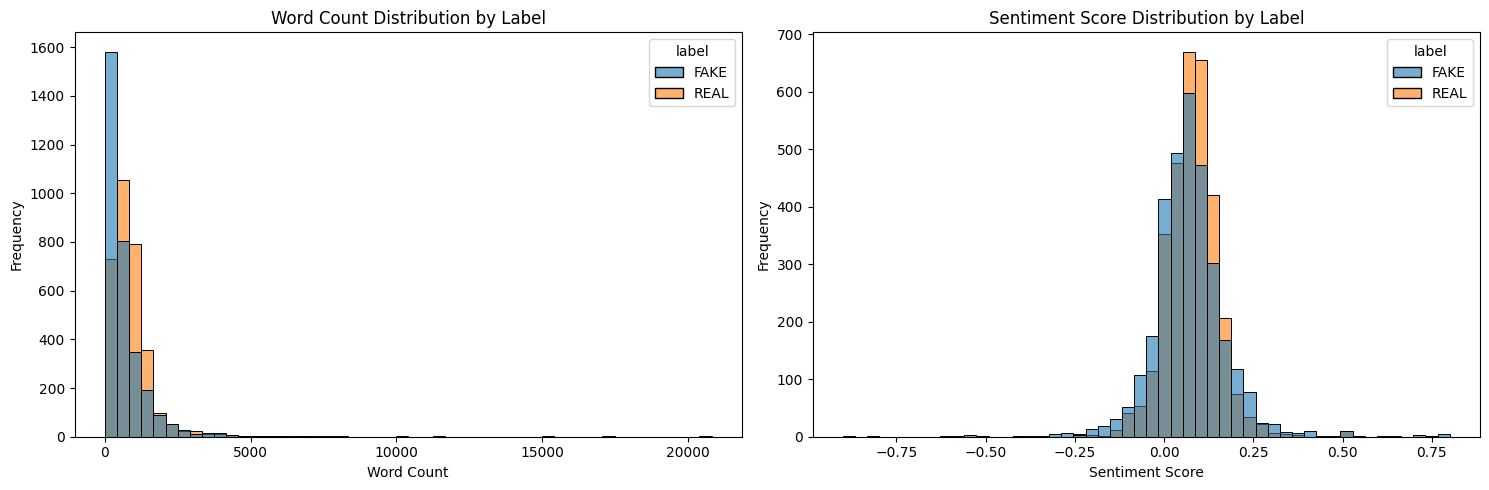

In [ ]:
# Load Dataset
df = pd.read_csv('/content/news.csv')

# Drop unnecessary and null rows
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.dropna(subset=['text'], inplace=True)

# Fill missing author names
if 'author' in df.columns:
    df['author'] = df['author'].fillna('Unknown')

# Text Cleaning
df['text'] = df['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

# Feature Engineering
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
print(df.columns)



df['title'] = df['title'].fillna('')

df['text'] = df['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['title'] = df['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(len)
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)#tht means -1=negative and 1=positive
df['text_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

print("\nWord Count Statistics:")
print(df['word_count'].describe())
print("\nCharacter Count Statistics:")
print(df['char_count'].describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x='word_count', hue='label', bins=50, alpha=0.6, ax=ax1)
ax1.set_title('Word Count Distribution by Label')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

sns.histplot(data=df, x='text_sentiment', hue='label', bins=50, alpha=0.6, ax=ax2)
ax2.set_title('Sentiment Score Distribution by Label')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()



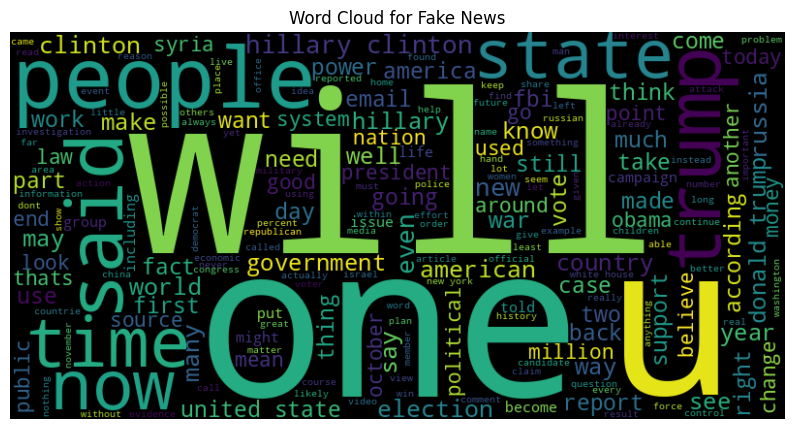

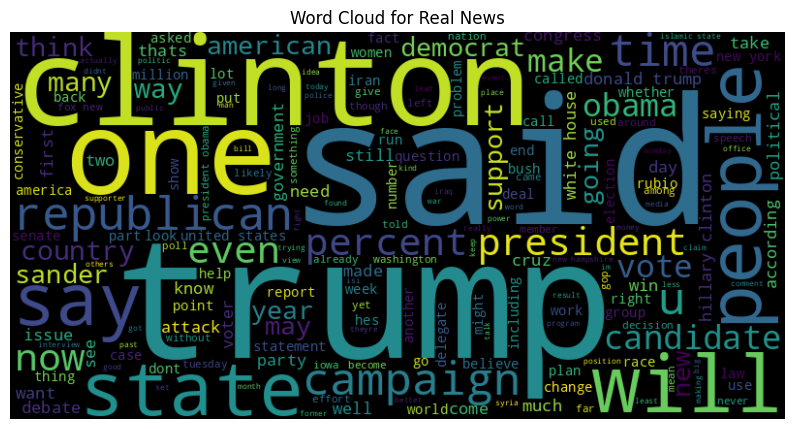

In [ ]:
# Separate Fake and Real News
fake_news = df[df['label'] == 'FAKE']
real_news = df[df['label'] == 'REAL']

# Word Clouds
plt.figure(figsize=(10, 8))
wordcloud_fake = WordCloud(width=800, height=400).generate(' '.join(fake_news['text']))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
wordcloud_real = WordCloud(width=800, height=400).generate(' '.join(real_news['text']))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Word Cloud for Real News')
plt.axis('off')
plt.show()


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text'])

# Combine Features
X_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_features['word_count'] = df['word_count']
X_features['char_count'] = df['char_count']
X_features['sentiment_score'] = df['sentiment_score']

# Target Variable
y = df['label']


Class Distribution: 
 label
REAL    3171
FAKE    3164
Name: count, dtype: int64
Resampled class distribution: 
label
FAKE    3171
REAL    3171
Name: count, dtype: int64


<ipython-input-20-748abbe0961a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='coolwarm')


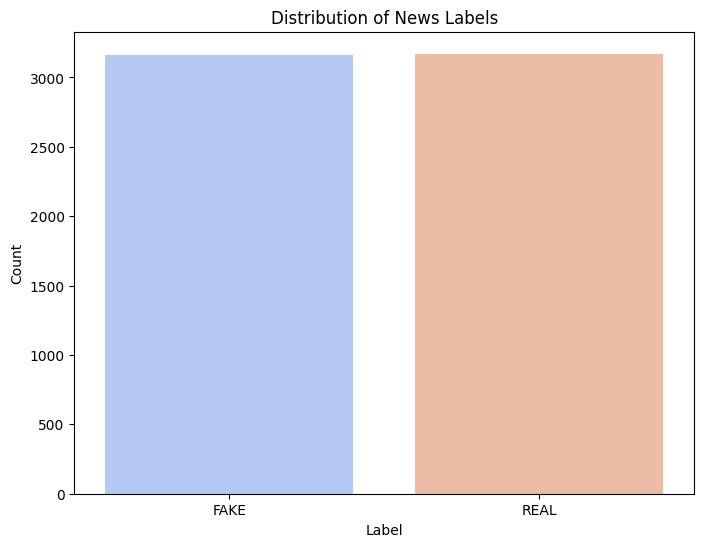

In [ ]:
# Class Balance
print("Class Distribution: \n", y.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_features, y)
print(f"Resampled class distribution: \n{y_res.value_counts()}")
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='coolwarm')
plt.title("Distribution of News Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics:
Accuracy: 0.9275
Precision: 0.9333
Recall: 0.9216
F1 Score: 0.9274
ROC-AUC: 0.9785



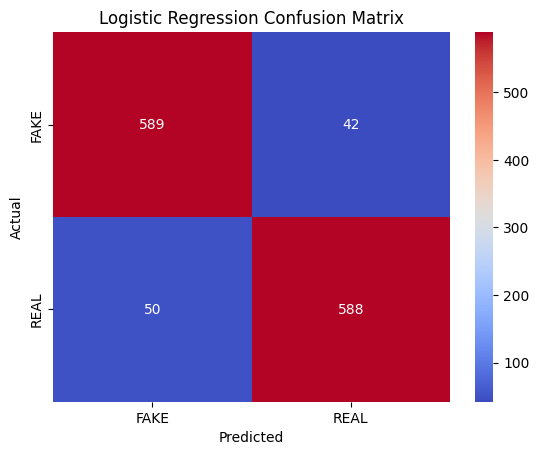

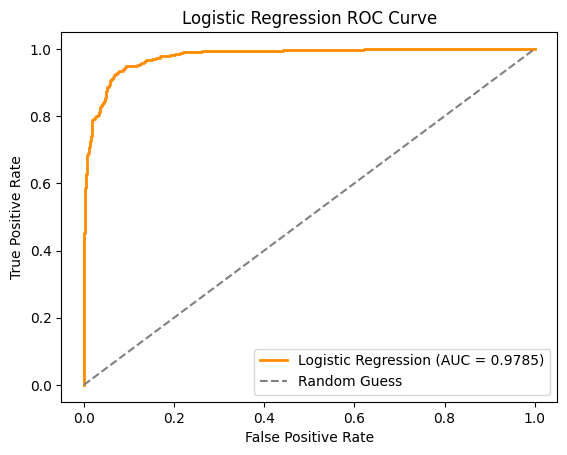

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
y_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, pos_label='REAL')
recall_log_reg = recall_score(y_test, y_pred_log_reg, pos_label='REAL')
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label='REAL')
roc_auc_log_reg = roc_auc_score(pd.get_dummies(y_test)['REAL'], y_proba_log_reg)

# Results
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1 Score: {f1_log_reg:.4f}")
print(f"ROC-AUC: {roc_auc_log_reg:.4f}\n")

# Confusion Matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg, labels=['FAKE', 'REAL'])
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='coolwarm', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(pd.get_dummies(y_test)['REAL'], y_proba_log_reg)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



Naive Bayes Metrics:
Accuracy: 0.8928
Precision: 0.8910
Recall: 0.8966
F1 Score: 0.8938
ROC-AUC: 0.9523



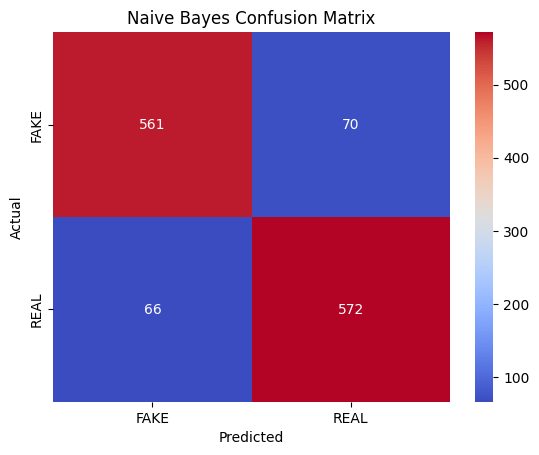

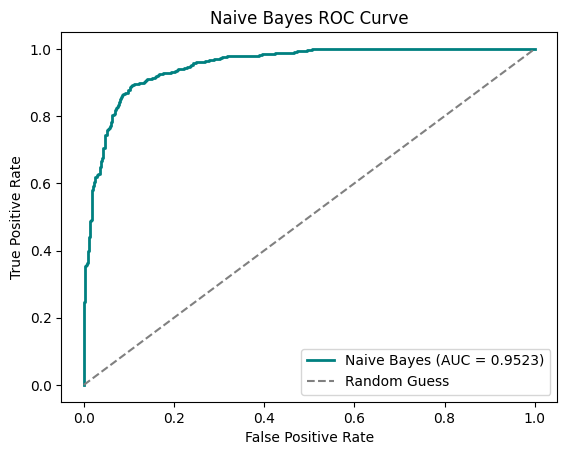

In [ ]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_nb, y_train_nb)

y_pred_nb = nb.predict(X_test_nb)
y_proba_nb = nb.predict_proba(X_test_nb)[:, 1]

# Metrics
accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
precision_nb = precision_score(y_test_nb, y_pred_nb, pos_label='REAL')
recall_nb = recall_score(y_test_nb, y_pred_nb, pos_label='REAL')
f1_nb = f1_score(y_test_nb, y_pred_nb, pos_label='REAL')
roc_auc_nb = roc_auc_score(pd.get_dummies(y_test_nb)['REAL'], y_proba_nb)

# Results
print("Naive Bayes Metrics:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")
print(f"ROC-AUC: {roc_auc_nb:.4f}\n")

# Confusion Matrix
cm_nb = confusion_matrix(y_test_nb, y_pred_nb, labels=['FAKE', 'REAL'])
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='coolwarm', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(pd.get_dummies(y_test_nb)['REAL'], y_proba_nb)
plt.plot(fpr, tpr, color='teal', lw=2, label=f"Naive Bayes (AUC = {roc_auc_nb:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Naive Bayes ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


Random Forest Metrics:
Accuracy: 0.9070
Precision: 0.9012
Recall: 0.9154
F1 Score: 0.9082
ROC-AUC: 0.9716



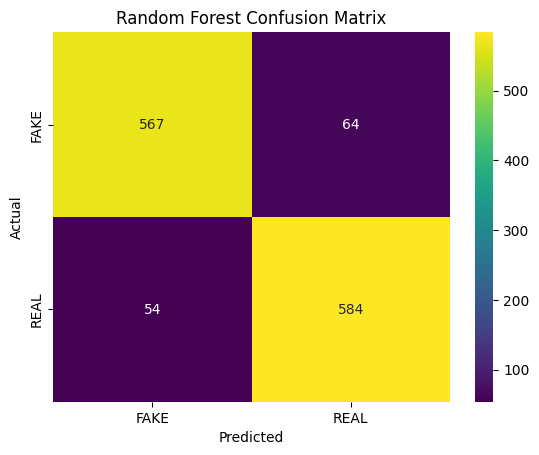

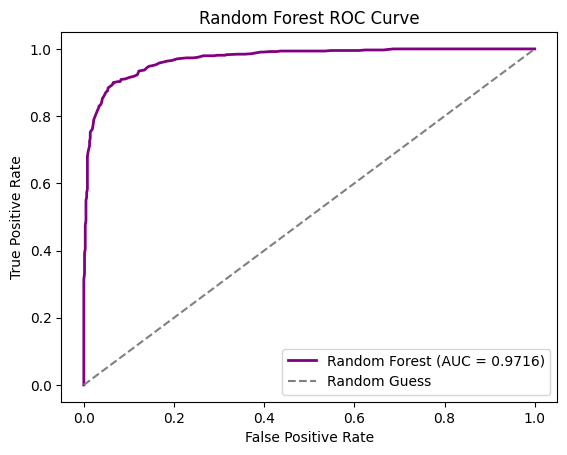

In [ ]:
# Random Forest
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, None]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label='REAL')
recall_rf = recall_score(y_test, y_pred_rf, pos_label='REAL')
f1_rf = f1_score(y_test, y_pred_rf, pos_label='REAL')
roc_auc_rf = roc_auc_score(pd.get_dummies(y_test)['REAL'], y_proba_rf)

# Results
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}\n")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['FAKE', 'REAL'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='viridis', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(pd.get_dummies(y_test)['REAL'], y_proba_rf)
plt.plot(fpr, tpr, color='purple', lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



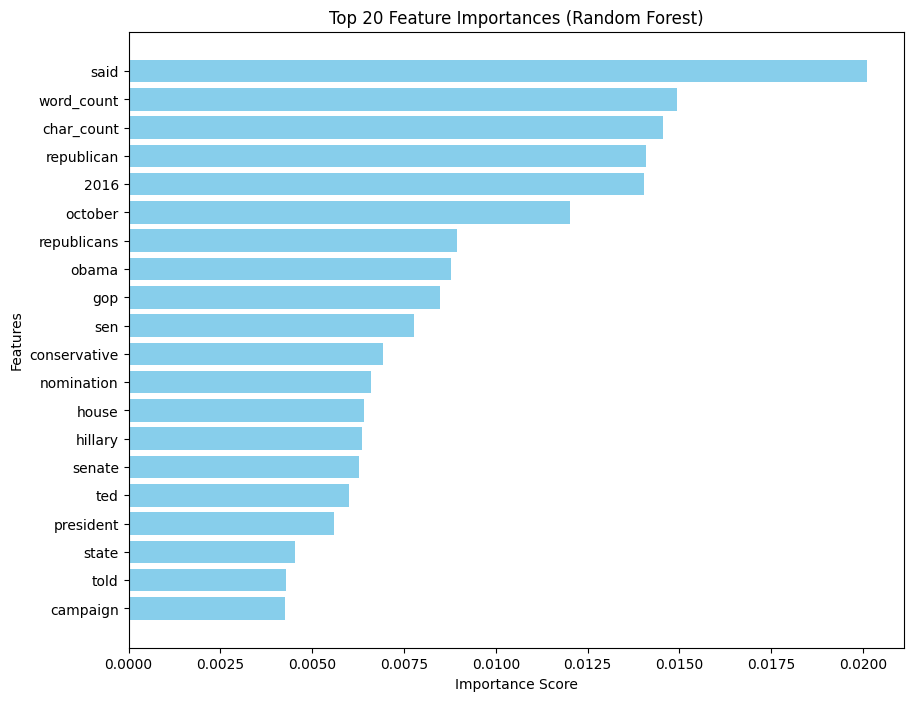

In [ ]:
# Get the indices of the top N features
top_n = 20
sorted_idx = np.argsort(feature_importances)[::-1][:top_n]

# Plot the top N features
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances[sorted_idx], color='skyblue')
plt.yticks(range(top_n), [X_features.columns[i] for i in sorted_idx])
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
